In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob

from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia

from deepposekit.models import (StackedDenseNet,
                                DeepLabCut,
                                StackedHourglass,
                                LEAP)
from deepposekit.models import load_model

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from deepposekit.callbacks import Logger, ModelCheckpoint


import time

In [2]:
import tensorflow as tf
devices = tf.config.list_physical_devices('GPU')
print(len(devices)) 

1


# Data generator

In [3]:
data_generator = DataGenerator('dataset/annotation_merged_3.h5')

C:\Users\Yixiong\Anaconda3\envs\deeppose\lib\site-packages\deepposekit\io\DataGenerator.py:81: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.annotated = np.all(h5file["annotated"].value, axis=1)


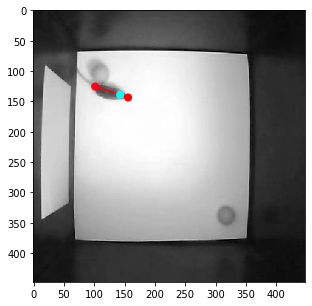

In [4]:
image, keypoints = data_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Data augmentation

In [5]:
augmenter = []

augmenter.append(FlipAxis(data_generator, axis=0))  # flip image up-down
augmenter.append(FlipAxis(data_generator, axis=1))  # flip image left-right 

sometimes = []
sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=(-180, 180),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)

C:\Users\Yixiong\Anaconda3\envs\deeppose\lib\site-packages\imgaug\augmenters\flip.py:986: DeprecationWarning: The parameter `deterministic` is deprecated in `imgaug.augmenters.meta.Augmenter`. Use `.to_deterministic()` to switch into deterministic mode.
  random_state=random_state, deterministic=deterministic)


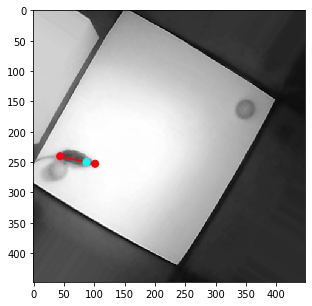

In [6]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Training generator

In [7]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=3,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=0.1, 
                                    use_graph=True,
                                    random_seed=1,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 969,
 'n_validation': 107,
 'validation_split': 0.1,
 'downsample_factor': 3,
 'output_shape': (56, 56),
 'n_output_channels': 8,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 0.625,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': True,
 'datapath': 'dataset/annotation_merged_3.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 1076,
 'image_shape': (448, 448, 1),
 'keypoints_shape': (3, 2)}

C:\Users\Yixiong\Anaconda3\envs\deeppose\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Method `Sequential.reseed()` is deprecated. Use `imgaug.augmenters.meta.Augmenter.seed_` instead.
  warn_deprecated(msg, stacklevel=3)


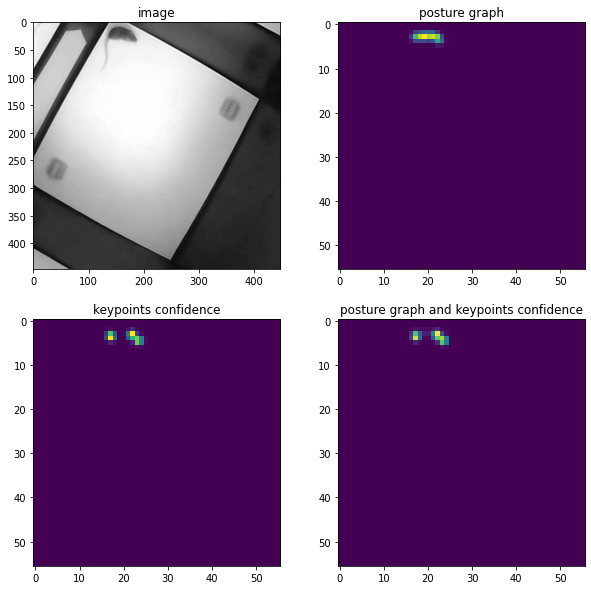

In [8]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

# Training

In [9]:
from deepposekit.models import StackedDenseNet

In [10]:
# Transfer learning
model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)


In [11]:
model.get_config()

{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 6,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 969,
 'n_validation': 107,
 'validation_split': 0.1,
 'downsample_factor': 3,
 'output_shape': (56, 56),
 'n_output_channels': 8,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 0.625,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': True,
 'datapath': 'dataset/annotation_merged_3.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 1076,
 'image_shape': (448, 448, 1),
 'keypoints_shape': (3, 2)}

In [12]:
logger = Logger(validation_batch_size=10,
    # filepath saves the logger data to a .h5 file
    # filepath=HOME + "/deepposekit-data/datasets/fly/log_densenet.h5"
)

In [13]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, verbose=1, patience=20)


In [14]:
model_checkpoint = ModelCheckpoint(
    'dataset/best_model_densenet_2.h5',
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    verbose=1,
    save_best_only=True,
)

In [15]:
early_stop = EarlyStopping(
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    min_delta=0.001,
    patience=100,
    verbose=1
)

In [16]:
%load_ext tensorboard

In [17]:
import datetime
log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [18]:
callbacks = [early_stop, reduce_lr, model_checkpoint, logger, tensorboard_callback]


In [ ]:
model.fit(
    batch_size=8,
    validation_batch_size=10,
    callbacks=callbacks,
    #epochs=1000, # Increase the number of epochs to train the model longer
    epochs=200,
    n_workers=8,
    steps_per_epoch=None,
)

Instructions for updating:
Please use Model.fit, which supports generators.


C:\Users\Yixiong\Anaconda3\envs\deeppose\lib\site-packages\deepposekit\models\engine.py:145: UserWarning: 
Automatically compiling with default settings: model.compile('adam', 'mse')
Call model.compile() manually to use non-default settings.

  """\nAutomatically compiling with default settings: model.compile('adam', 'mse')\n"""


Train for 121 steps, validate for 10 steps
Epoch 1/200
120/121 [============================>.] - ETA: 0s - loss: 30.5613 - output_0_loss: 10.3757 - output_1_loss: 10.1275 - output_2_loss: 10.0581
Epoch 00001: val_loss improved from inf to 52.99568, saving model to dataset/best_model_densenet_2.h5
evaluation_metrics: 
euclidean - mean:  8.31 (0%:  0.14, 5%:  0.72, 25%:  1.66, 50%:  3.38, 75%:  6.90, 95%: 40.71, 100%: 60.73) 
confidence - mean:  0.09 (0%:  0.00, 5%:  0.01, 25%:  0.04, 50%:  0.07, 75%:  0.12, 95%:  0.20, 100%:  0.26) 

121/121 [==============================] - 123s 1s/step - loss: 30.4735 - output_0_loss: 10.3468 - output_1_loss: 10.0985 - output_2_loss: 10.0282 - val_loss: 52.9957 - val_output_0_loss: 17.2357 - val_output_1_loss: 17.8746 - val_output_2_loss: 17.8854
Epoch 2/200
120/121 [============================>.] - ETA: 0s - loss: 15.3903 - output_0_loss: 5.2921 - output_1_loss: 5.0714 - output_2_loss: 5.0268
Epoch 00002: val_loss improved from 52.99568 to 33.7775

evaluation_metrics: 
euclidean - mean:  1.85 (0%:  0.11, 5%:  0.34, 25%:  0.81, 50%:  1.33, 75%:  1.94, 95%:  4.17, 100%: 29.48) 
confidence - mean:  0.74 (0%:  0.10, 5%:  0.57, 25%:  0.68, 50%:  0.75, 75%:  0.82, 95%:  0.91, 100%:  0.96) 

121/121 [==============================] - 108s 889ms/step - loss: 6.6147 - output_0_loss: 2.3839 - output_1_loss: 2.1428 - output_2_loss: 2.0879 - val_loss: 5.7525 - val_output_0_loss: 2.0554 - val_output_1_loss: 1.8764 - val_output_2_loss: 1.8207
Epoch 13/200
120/121 [============================>.] - ETA: 0s - loss: 5.6476 - output_0_loss: 2.0085 - output_1_loss: 1.8344 - output_2_loss: 1.8047
Epoch 00013: val_loss improved from 5.75246 to 5.23478, saving model to dataset/best_model_densenet_2.h5
evaluation_metrics: 
euclidean - mean:  1.55 (0%:  0.11, 5%:  0.34, 25%:  0.79, 50%:  1.29, 75%:  1.86, 95%:  3.55, 100%:  8.86) 
confidence - mean:  0.76 (0%:  0.08, 5%:  0.54, 25%:  0.69, 50%:  0.77, 75%:  0.84, 95%:  0.92, 100%:  1.03) 

121/121 [====

Epoch 24/200
120/121 [============================>.] - ETA: 0s - loss: 4.9060 - output_0_loss: 1.7539 - output_1_loss: 1.5946 - output_2_loss: 1.5575
Epoch 00024: val_loss improved from 4.86519 to 4.21393, saving model to dataset/best_model_densenet_2.h5
evaluation_metrics: 
euclidean - mean:  1.47 (0%:  0.08, 5%:  0.25, 25%:  0.68, 50%:  1.05, 75%:  1.70, 95%:  3.29, 100%: 29.42) 
confidence - mean:  0.77 (0%:  0.11, 5%:  0.58, 25%:  0.70, 50%:  0.77, 75%:  0.85, 95%:  0.93, 100%:  1.01) 

121/121 [==============================] - 109s 900ms/step - loss: 4.9466 - output_0_loss: 1.7636 - output_1_loss: 1.6099 - output_2_loss: 1.5731 - val_loss: 4.2139 - val_output_0_loss: 1.5193 - val_output_1_loss: 1.3774 - val_output_2_loss: 1.3172
Epoch 25/200
120/121 [============================>.] - ETA: 0s - loss: 5.3412 - output_0_loss: 1.9277 - output_1_loss: 1.7274 - output_2_loss: 1.6861
Epoch 00025: val_loss did not improve from 4.21393
evaluation_metrics: 
euclidean - mean:  2.40 (0%:  0

Epoch 36/200
120/121 [============================>.] - ETA: 0s - loss: 5.0562 - output_0_loss: 1.7837 - output_1_loss: 1.6489 - output_2_loss: 1.6236
Epoch 00036: val_loss did not improve from 3.85313
evaluation_metrics: 
euclidean - mean:  1.82 (0%:  0.11, 5%:  0.32, 25%:  0.67, 50%:  1.15, 75%:  1.69, 95%:  3.72, 100%: 40.18) 
confidence - mean:  0.76 (0%:  0.14, 5%:  0.58, 25%:  0.68, 50%:  0.76, 75%:  0.85, 95%:  0.93, 100%:  1.05) 

121/121 [==============================] - 109s 904ms/step - loss: 5.0559 - output_0_loss: 1.7833 - output_1_loss: 1.6489 - output_2_loss: 1.6236 - val_loss: 4.9019 - val_output_0_loss: 1.6741 - val_output_1_loss: 1.6376 - val_output_2_loss: 1.5902
Epoch 37/200
120/121 [============================>.] - ETA: 0s - loss: 4.7661 - output_0_loss: 1.7006 - output_1_loss: 1.5417 - output_2_loss: 1.5239
Epoch 00037: val_loss did not improve from 3.85313
evaluation_metrics: 
euclidean - mean:  1.64 (0%:  0.08, 5%:  0.25, 25%:  0.72, 50%:  1.19, 75%:  1.73, 95

Epoch 48/200
120/121 [============================>.] - ETA: 0s - loss: 4.1140 - output_0_loss: 1.4552 - output_1_loss: 1.3394 - output_2_loss: 1.3195
Epoch 00048: val_loss did not improve from 3.85313
evaluation_metrics: 
euclidean - mean:  1.49 (0%:  0.05, 5%:  0.29, 25%:  0.62, 50%:  1.07, 75%:  1.71, 95%:  3.28, 100%: 28.97) 
confidence - mean:  0.76 (0%:  0.09, 5%:  0.57, 25%:  0.70, 50%:  0.77, 75%:  0.85, 95%:  0.93, 100%:  0.98) 

121/121 [==============================] - 155s 1s/step - loss: 4.1018 - output_0_loss: 1.4506 - output_1_loss: 1.3355 - output_2_loss: 1.3156 - val_loss: 4.2487 - val_output_0_loss: 1.4871 - val_output_1_loss: 1.4041 - val_output_2_loss: 1.3575
Epoch 49/200
120/121 [============================>.] - ETA: 0s - loss: 4.6473 - output_0_loss: 1.6443 - output_1_loss: 1.5172 - output_2_loss: 1.4858
Epoch 00049: val_loss did not improve from 3.85313
evaluation_metrics: 
euclidean - mean:  1.41 (0%:  0.09, 5%:  0.29, 25%:  0.69, 50%:  1.04, 75%:  1.68, 95%: 

Epoch 60/200
120/121 [============================>.] - ETA: 0s - loss: 4.2176 - output_0_loss: 1.4941 - output_1_loss: 1.3708 - output_2_loss: 1.3528
Epoch 00060: val_loss did not improve from 3.60678
evaluation_metrics: 
euclidean - mean:  2.07 (0%:  0.08, 5%:  0.28, 25%:  0.66, 50%:  1.02, 75%:  1.71, 95%:  3.91, 100%: 58.89) 
confidence - mean:  0.78 (0%:  0.03, 5%:  0.61, 25%:  0.73, 50%:  0.80, 75%:  0.86, 95%:  0.95, 100%:  1.01) 

121/121 [==============================] - 154s 1s/step - loss: 4.2240 - output_0_loss: 1.4952 - output_1_loss: 1.3734 - output_2_loss: 1.3554 - val_loss: 4.2028 - val_output_0_loss: 1.4753 - val_output_1_loss: 1.3682 - val_output_2_loss: 1.3592
Epoch 61/200
120/121 [============================>.] - ETA: 0s - loss: 3.8030 - output_0_loss: 1.3311 - output_1_loss: 1.2422 - output_2_loss: 1.2297
Epoch 00061: val_loss did not improve from 3.60678
evaluation_metrics: 
euclidean - mean:  1.85 (0%:  0.07, 5%:  0.32, 25%:  0.66, 50%:  1.09, 75%:  1.65, 95%: 

Epoch 72/200
120/121 [============================>.] - ETA: 0s - loss: 3.8238 - output_0_loss: 1.3478 - output_1_loss: 1.2498 - output_2_loss: 1.2261
Epoch 00072: val_loss did not improve from 3.14821
evaluation_metrics: 
euclidean - mean:  1.33 (0%:  0.08, 5%:  0.29, 25%:  0.69, 50%:  1.08, 75%:  1.61, 95%:  2.96, 100%: 12.70) 
confidence - mean:  0.79 (0%:  0.36, 5%:  0.60, 25%:  0.72, 50%:  0.79, 75%:  0.87, 95%:  0.96, 100%:  1.02) 

121/121 [==============================] - 113s 930ms/step - loss: 3.8200 - output_0_loss: 1.3465 - output_1_loss: 1.2488 - output_2_loss: 1.2248 - val_loss: 3.3143 - val_output_0_loss: 1.1937 - val_output_1_loss: 1.0703 - val_output_2_loss: 1.0503
Epoch 73/200
120/121 [============================>.] - ETA: 0s - loss: 4.0305 - output_0_loss: 1.4102 - output_1_loss: 1.3182 - output_2_loss: 1.3020
Epoch 00073: val_loss did not improve from 3.14821
evaluation_metrics: 
euclidean - mean:  1.37 (0%:  0.08, 5%:  0.25, 25%:  0.61, 50%:  1.01, 75%:  1.61, 95

Epoch 84/200
120/121 [============================>.] - ETA: 0s - loss: 3.4401 - output_0_loss: 1.1861 - output_1_loss: 1.1356 - output_2_loss: 1.1184
Epoch 00084: val_loss did not improve from 3.00913
evaluation_metrics: 
euclidean - mean:  1.25 (0%:  0.00, 5%:  0.25, 25%:  0.62, 50%:  0.97, 75%:  1.58, 95%:  2.80, 100%: 13.26) 
confidence - mean:  0.78 (0%:  0.03, 5%:  0.60, 25%:  0.70, 50%:  0.78, 75%:  0.86, 95%:  0.94, 100%:  0.98) 

121/121 [==============================] - 111s 917ms/step - loss: 3.4494 - output_0_loss: 1.1901 - output_1_loss: 1.1387 - output_2_loss: 1.1206 - val_loss: 3.4548 - val_output_0_loss: 1.2084 - val_output_1_loss: 1.1243 - val_output_2_loss: 1.1221
Epoch 85/200
120/121 [============================>.] - ETA: 0s - loss: 3.8114 - output_0_loss: 1.3262 - output_1_loss: 1.2499 - output_2_loss: 1.2353
Epoch 00085: val_loss did not improve from 3.00913
evaluation_metrics: 
euclidean - mean:  1.34 (0%:  0.11, 5%:  0.29, 25%:  0.64, 50%:  0.97, 75%:  1.57, 95

Epoch 96/200
120/121 [============================>.] - ETA: 0s - loss: 4.1912 - output_0_loss: 1.4638 - output_1_loss: 1.3747 - output_2_loss: 1.3526
Epoch 00096: val_loss did not improve from 3.00913
evaluation_metrics: 
euclidean - mean:  1.32 (0%:  0.03, 5%:  0.24, 25%:  0.65, 50%:  0.97, 75%:  1.58, 95%:  3.25, 100%: 14.69) 
confidence - mean:  0.79 (0%:  0.05, 5%:  0.59, 25%:  0.71, 50%:  0.79, 75%:  0.89, 95%:  0.98, 100%:  1.02) 

121/121 [==============================] - 143s 1s/step - loss: 4.1910 - output_0_loss: 1.4644 - output_1_loss: 1.3744 - output_2_loss: 1.3521 - val_loss: 3.6906 - val_output_0_loss: 1.2901 - val_output_1_loss: 1.2207 - val_output_2_loss: 1.1798
Epoch 97/200
120/121 [============================>.] - ETA: 0s - loss: 3.8622 - output_0_loss: 1.3384 - output_1_loss: 1.2714 - output_2_loss: 1.2524
Epoch 00097: val_loss did not improve from 3.00913
evaluation_metrics: 
euclidean - mean:  1.36 (0%:  0.00, 5%:  0.25, 25%:  0.68, 50%:  1.09, 75%:  1.67, 95%: 

121/121 [==============================] - 109s 904ms/step - loss: 2.6863 - output_0_loss: 0.9311 - output_1_loss: 0.8837 - output_2_loss: 0.8716 - val_loss: 2.5729 - val_output_0_loss: 0.9147 - val_output_1_loss: 0.8454 - val_output_2_loss: 0.8128
Epoch 108/200
120/121 [============================>.] - ETA: 0s - loss: 2.6754 - output_0_loss: 0.9286 - output_1_loss: 0.8791 - output_2_loss: 0.8677
Epoch 00108: val_loss improved from 2.53076 to 2.46806, saving model to dataset/best_model_densenet_2.h5
evaluation_metrics: 
euclidean - mean:  1.11 (0%:  0.00, 5%:  0.18, 25%:  0.57, 50%:  0.91, 75%:  1.41, 95%:  2.66, 100%:  7.88) 
confidence - mean:  0.80 (0%:  0.38, 5%:  0.61, 25%:  0.72, 50%:  0.80, 75%:  0.88, 95%:  0.96, 100%:  1.00) 

121/121 [==============================] - 112s 923ms/step - loss: 2.6798 - output_0_loss: 0.9301 - output_1_loss: 0.8806 - output_2_loss: 0.8692 - val_loss: 2.4681 - val_output_0_loss: 0.8835 - val_output_1_loss: 0.8080 - val_output_2_loss: 0.7766
Epoc

121/121 [==============================] - 109s 904ms/step - loss: 2.6191 - output_0_loss: 0.8989 - output_1_loss: 0.8650 - output_2_loss: 0.8552 - val_loss: 2.4235 - val_output_0_loss: 0.8656 - val_output_1_loss: 0.7875 - val_output_2_loss: 0.7704
Epoch 120/200
120/121 [============================>.] - ETA: 0s - loss: 2.5552 - output_0_loss: 0.8876 - output_1_loss: 0.8386 - output_2_loss: 0.8290
Epoch 00120: val_loss did not improve from 2.41885
evaluation_metrics: 
euclidean - mean:  1.25 (0%:  0.02, 5%:  0.18, 25%:  0.56, 50%:  0.91, 75%:  1.54, 95%:  3.02, 100%: 22.41) 
confidence - mean:  0.79 (0%:  0.38, 5%:  0.60, 25%:  0.71, 50%:  0.80, 75%:  0.88, 95%:  0.96, 100%:  1.00) 

121/121 [==============================] - 112s 924ms/step - loss: 2.6206 - output_0_loss: 0.9088 - output_1_loss: 0.8607 - output_2_loss: 0.8511 - val_loss: 2.6783 - val_output_0_loss: 0.9472 - val_output_1_loss: 0.8740 - val_output_2_loss: 0.8571
Epoch 121/200
120/121 [============================>.] - E

121/121 [==============================] - 110s 905ms/step - loss: 2.6479 - output_0_loss: 0.9125 - output_1_loss: 0.8717 - output_2_loss: 0.8637 - val_loss: 2.4459 - val_output_0_loss: 0.8613 - val_output_1_loss: 0.7966 - val_output_2_loss: 0.7880
Epoch 132/200
120/121 [============================>.] - ETA: 0s - loss: 2.6007 - output_0_loss: 0.9035 - output_1_loss: 0.8555 - output_2_loss: 0.8417
Epoch 00132: val_loss improved from 2.40414 to 2.35569, saving model to dataset/best_model_densenet_2.h5
evaluation_metrics: 
euclidean - mean:  1.11 (0%:  0.08, 5%:  0.23, 25%:  0.53, 50%:  0.87, 75%:  1.42, 95%:  2.96, 100%:  5.13) 
confidence - mean:  0.79 (0%:  0.49, 5%:  0.61, 25%:  0.72, 50%:  0.79, 75%:  0.88, 95%:  0.96, 100%:  0.99) 

121/121 [==============================] - 112s 927ms/step - loss: 2.5957 - output_0_loss: 0.9016 - output_1_loss: 0.8539 - output_2_loss: 0.8402 - val_loss: 2.3557 - val_output_0_loss: 0.8357 - val_output_1_loss: 0.7653 - val_output_2_loss: 0.7547
Epoc

evaluation_metrics: 
euclidean - mean:  1.17 (0%:  0.03, 5%:  0.23, 25%:  0.54, 50%:  0.88, 75%:  1.44, 95%:  2.78, 100%: 23.04) 
confidence - mean:  0.79 (0%:  0.51, 5%:  0.60, 25%:  0.73, 50%:  0.80, 75%:  0.87, 95%:  0.96, 100%:  1.00) 

121/121 [==============================] - 112s 925ms/step - loss: 2.4539 - output_0_loss: 0.8473 - output_1_loss: 0.8102 - output_2_loss: 0.7964 - val_loss: 2.3615 - val_output_0_loss: 0.8388 - val_output_1_loss: 0.7719 - val_output_2_loss: 0.7509
Epoch 144/200
120/121 [============================>.] - ETA: 0s - loss: 2.5288 - output_0_loss: 0.8637 - output_1_loss: 0.8380 - output_2_loss: 0.8272
Epoch 00144: val_loss did not improve from 2.30545
evaluation_metrics: 
euclidean - mean:  1.18 (0%:  0.00, 5%:  0.18, 25%:  0.54, 50%:  0.91, 75%:  1.47, 95%:  2.84, 100%: 23.22) 
confidence - mean:  0.80 (0%:  0.42, 5%:  0.61, 25%:  0.72, 50%:  0.80, 75%:  0.87, 95%:  0.96, 100%:  1.00) 

121/121 [==============================] - 111s 918ms/step - loss:

Epoch 167/200
120/121 [============================>.] - ETA: 0s - loss: 2.3350 - output_0_loss: 0.8068 - output_1_loss: 0.7700 - output_2_loss: 0.7582
Epoch 00167: val_loss did not improve from 2.30545
evaluation_metrics: 
euclidean - mean:  1.09 (0%:  0.07, 5%:  0.22, 25%:  0.56, 50%:  0.88, 75%:  1.42, 95%:  2.71, 100%:  7.42) 
confidence - mean:  0.80 (0%:  0.53, 5%:  0.60, 25%:  0.73, 50%:  0.80, 75%:  0.88, 95%:  0.96, 100%:  0.99) 

121/121 [==============================] - 112s 926ms/step - loss: 2.3323 - output_0_loss: 0.8058 - output_1_loss: 0.7691 - output_2_loss: 0.7574 - val_loss: 2.5648 - val_output_0_loss: 0.8939 - val_output_1_loss: 0.8413 - val_output_2_loss: 0.8296
Epoch 168/200
120/121 [============================>.] - ETA: 0s - loss: 2.3157 - output_0_loss: 0.8021 - output_1_loss: 0.7640 - output_2_loss: 0.7496
Epoch 00168: val_loss did not improve from 2.30545
evaluation_metrics: 
euclidean - mean:  1.19 (0%:  0.03, 5%:  0.23, 25%:  0.54, 50%:  0.89, 75%:  1.48, 

Epoch 179/200
120/121 [============================>.] - ETA: 0s - loss: 2.2368 - output_0_loss: 0.7725 - output_1_loss: 0.7373 - output_2_loss: 0.7270
Epoch 00179: val_loss did not improve from 2.30545
evaluation_metrics: 
euclidean - mean:  1.13 (0%:  0.00, 5%:  0.23, 25%:  0.51, 50%:  0.87, 75%:  1.42, 95%:  2.61, 100%: 23.46) 
confidence - mean:  0.79 (0%:  0.53, 5%:  0.60, 25%:  0.72, 50%:  0.80, 75%:  0.87, 95%:  0.95, 100%:  0.98) 

121/121 [==============================] - 112s 923ms/step - loss: 2.2341 - output_0_loss: 0.7716 - output_1_loss: 0.7364 - output_2_loss: 0.7261 - val_loss: 2.4022 - val_output_0_loss: 0.8480 - val_output_1_loss: 0.7865 - val_output_2_loss: 0.7678
Epoch 180/200
120/121 [============================>.] - ETA: 0s - loss: 2.2696 - output_0_loss: 0.7816 - output_1_loss: 0.7488 - output_2_loss: 0.7392
Epoch 00180: val_loss did not improve from 2.30545
evaluation_metrics: 
euclidean - mean:  1.16 (0%:  0.00, 5%:  0.23, 25%:  0.53, 50%:  0.89, 75%:  1.44, 

In [19]:
model.fit?